In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import random
%matplotlib inline 

In [2]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters 
chars = sorted(list(set(''.join(word for word in words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0 
itos = {i: ch for ch, i in stoi.items()}
print(itos)
vocab_size = len(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# create the dataset 
def build_dataset(words, block_size):
    # block_size = 3 # how many characters to take to predict the next character 
    X, Y = [], [] 
    for word in words:
        # print(word)
        context = [0] * block_size 
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            # print(''.join(itos[i] for i in context), '------>', itos[ix])    
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) 
n2 = int(len(words) * 0.9)

block_size = 3 

Xtr, Ytr = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size) # 10%
Xte, Yte = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [166]:
# parameters setting 
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200 
C = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3) * (n_embd * block_size)**-0.5 #* 0.2 
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # we don't need it because BN subtracts the mean(bias) anyways.
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 
b2 = torch.randn(vocab_size,                       generator=g) * 0
bngain = torch.ones((1, n_hidden)) # gamma for BN 
bnbias = torch.zeros((1, n_hidden)) # beta for BN 
bnmean_running = torch.zeros((1, n_hidden)) # running average 
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"number of parameters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of parameters = 12097


In [167]:
max_steps = 200000
batch_size = 32 
lossi = [] 

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 #+ b1

    # batch normalization 
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True) + bnbias 

    with torch.no_grad(): # no gradient tracking needed 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # logtits as input. 

    # backward pass 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.303339
  10000/ 200000: 2.033922
  20000/ 200000: 1.917250
  30000/ 200000: 2.365371
  40000/ 200000: 2.107840
  50000/ 200000: 2.080066
  60000/ 200000: 2.092904
  70000/ 200000: 2.370324
  80000/ 200000: 2.439475
  90000/ 200000: 2.578929
 100000/ 200000: 2.388761
 110000/ 200000: 2.494926
 120000/ 200000: 2.011353
 130000/ 200000: 1.766294
 140000/ 200000: 2.386097
 150000/ 200000: 2.352748
 160000/ 200000: 1.898366
 170000/ 200000: 2.173161
 180000/ 200000: 2.332824
 190000/ 200000: 2.267527


In [44]:
# loss for uniform random distribtution 
# Our loss (at initialization) should be at least similar. 
print(f'uniform random prediction case: loss= {-torch.tensor(1/vocab_size).log().item()}')

# However, without good initalization, loss would be much larger then this value, and
# we would be wasting our time to do just easy work. 
# In our case, it seems the output of the last layer at intialization is overconfident for wrong predictions. 
# It can make loss very large. 
logits = torch.tensor([0.25, -0.25, 0.25, 0.25]) * 50
probs = F.softmax(logits, 0)
print(f'just simple 4 prediction case with overconfidence for wrong predictions: loss={-probs[1].log().item()}')

uniform random prediction case: loss= 3.295836925506592
just simple 4 prediction case with overconfidence for wrong predictions: loss=26.09861183166504


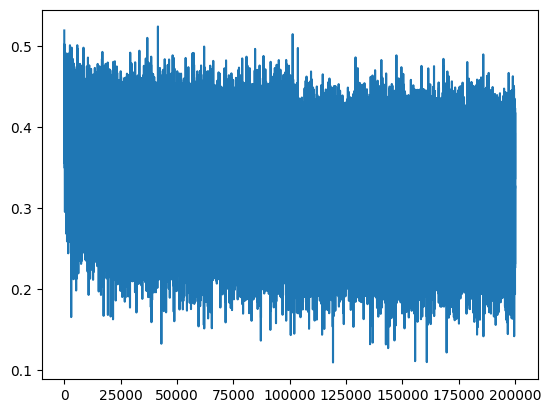

In [168]:
plt.plot(lossi)

In [157]:
# calibrate the batch norm at the end of training 
emb = C[Xtr] 
embcat = emb.view(-1, n_embd * block_size)
hpreact = embcat @ W1 + b1
bnmean = hpreact.mean(0, keepdims=True) 
bnstd = hpreact.std(0, keepdims=True)

In [161]:
@torch.no_grad() 
def split_loss(split, bn=True):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    if bn:
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [169]:
split_loss('train')
split_loss('val')

train 2.0664103031158447
val 2.1099743843078613


In [172]:
## ---------result---------- ## 

## vanilla 
# train 2.130587100982666
# val 2.1708500385284424

## +scale down the last layer's weight --> fix softmax confidently wrong 
# train 2.070660352706909
# val 2.134049654006958

## +fix tanh too saturated at init
# train 2.035435676574707
# val 2.1000843048095703

## kaiming init for tanh layer - gain was very similar to the previous one and the network is simple, so not much difference. 
# train 2.037860870361328
# val 2.1081783771514893

## unit guassian BN - forced zero-mean unit gaussian activations make it worse. 
# train 2.0760958194732666
# val 2.1139254570007324

## apply BN with trainable mean/std 
# train 2.0670766830444336
# val 2.1127257347106934

## BN with running mean/std
# train 2.0657734870910645
# val 2.1098971366882324

## BN bias=False 
# train 2.0664103031158447
# val 2.1099743843078613



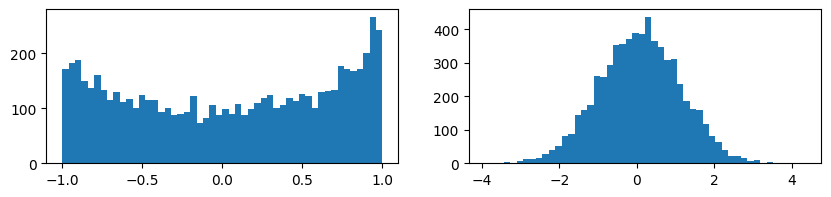

In [82]:
# diagnostic tools
# activations statistics 

# for tanh, if act value is near 1.0, the gradient value would be near 0.  (dtanh = 1-tanh**2) 
# which means, the neurons behind tanh won't get updated due to near-zero gradient. 
# --> dead neurons. 
plt.figure(figsize=(10, 2))
plt.subplot(1,2,1)
plt.hist(h.view(-1).tolist(), 50);
plt.subplot(1,2,2)
plt.hist(hpreact.view(-1).tolist(), 50);

1.296875% is saturated


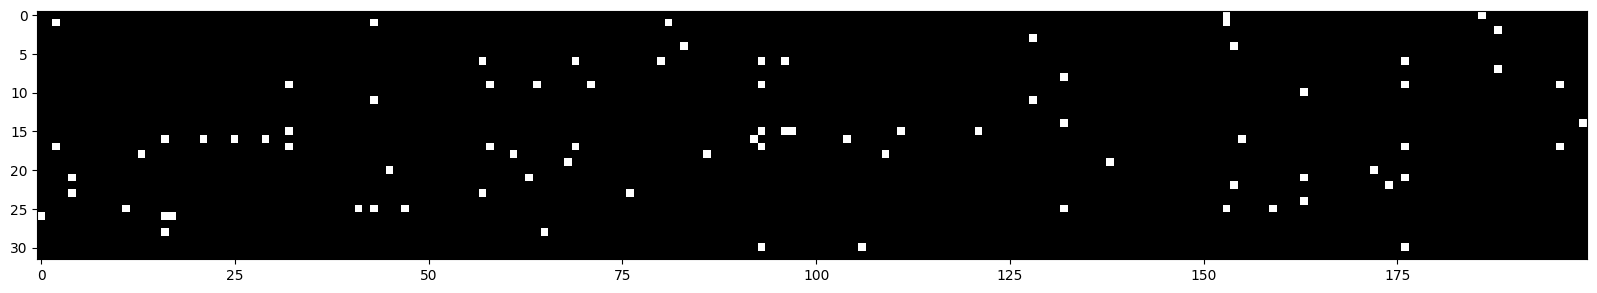

In [81]:
plt.figure(figsize=(20, 10))
print(f"{(h.abs() > 0.99).sum().item() / len(h.view(-1)) * 100}% is saturated")
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 

In [101]:
# variance(std**2) propagation through linear layers 
x = torch.randn(1000, 10) 
w = torch.randn(10, 20) * (10 ** -0.5)
y = x @ w 
h = torch.tanh(y)
print(f"x: mean/std = {x.mean().item(), x.std().item()}")
print(f"y: mean/std = {y.mean().item(), y.std().item()}")
print(f"h: mean/std = {h.mean().item(), h.std().item()}")

x: mean/std = (-0.0131724514067173, 1.005568027496338)
y: mean/std = (-0.004341845866292715, 1.014083981513977)
h: mean/std = (-0.005608119070529938, 0.613585889339447)


In [27]:
# sampling 

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = [] 
    context = [0] * block_size 
    while True:
        emb = C[context] 
        embcat = emb.view(-1, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix] 
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[ix] for ix in out))

dex.
malomonie.
rochitah.
melliston.
inrlenak.
katha.
samiyah.
javer.
gotai.
molie.
caiu.
kented.
jena.
millsede.
enkamirry.
folsp.
huckennatallys.
dasdro.
leenley.
alaisa.


## Pytorch-fy and refactor the code

In [46]:
# identical to pytorch nn module api 

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None 
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias 
        return self.out 
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps 
        self.momentum = momentum 
        self.training = True 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        # trainable parameters through backprop 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x - xmean) / (torch.sqrt(xvar) + self.eps) # normalization 
        self.out = self.gamma * xhat + self.beta # scaling and shift 

        # update running mean/var 
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var 
        return self.out 
        
    def parameters(self):
        return [self.gamma, self.beta] 

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
        
    def parameters(self):
        return [] 

In [47]:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 100 
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]


# E01 setting. 
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=True), Tanh(),
#     Linear(n_hidden, n_hidden, bias=True), Tanh(),
#     Linear(n_hidden, n_hidden, bias=True), Tanh(),
#     Linear(n_hidden, n_hidden, bias=True), Tanh(),
#     Linear(n_hidden, n_hidden, bias=True), Tanh(),
#     Linear(n_hidden, vocab_size, bias=True),
# ]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # make last layer less confident 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain for tanh 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"number of paramters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of paramters = 47024


In [53]:
max_steps = 200000
batch_size = 32 
lossi = [] 
ud = []

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  

    # backward pass 
    for layer in layers:
        layer.out.retain_grad() # DEBUGGING gradient 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    # if i > 1000:
    #     break # DEBUG purpose 

      0/ 200000: 2.335530
  10000/ 200000: 2.143044
  20000/ 200000: 2.123826
  30000/ 200000: 2.117269
  40000/ 200000: 2.411984
  50000/ 200000: 1.744091
  60000/ 200000: 1.826968
  70000/ 200000: 2.009197
  80000/ 200000: 2.233203
  90000/ 200000: 2.157028
 100000/ 200000: 1.729797
 110000/ 200000: 1.801652
 120000/ 200000: 2.249520
 130000/ 200000: 1.833391
 140000/ 200000: 2.153937
 150000/ 200000: 2.177668
 160000/ 200000: 1.731825
 170000/ 200000: 2.337142
 180000/ 200000: 2.188119
 190000/ 200000: 2.192106


layer 2 (Tanh      ): mean -0.00, std 0.68, saturated 14.12%
layer 5 (Tanh      ): mean 0.01, std 0.72, saturated 15.91%
layer 8 (Tanh      ): mean -0.01, std 0.74, saturated 15.81%
layer 11 (Tanh      ): mean 0.02, std 0.77, saturated 16.12%
layer 14 (Tanh      ): mean -0.01, std 0.78, saturated 18.41%


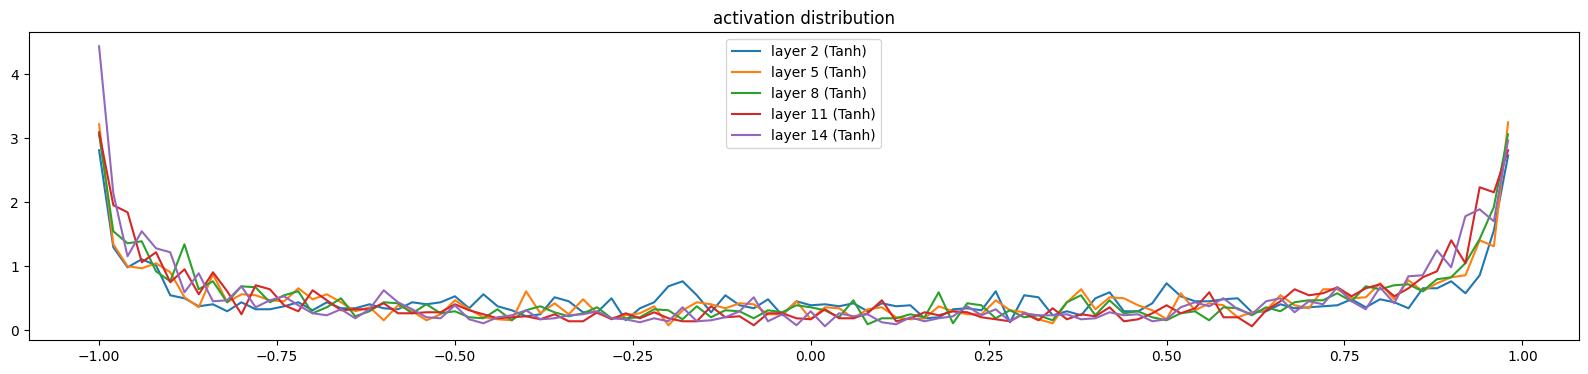

In [54]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh) or i == len(layers)-1:
        t = layer.out 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():.2f}, std {t.std().item():.2f}, saturated {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title('activation distribution');

layer 2 (Tanh      ): mean 0.000000, std 5.763776e-03
layer 5 (Tanh      ): mean -0.000000, std 4.599364e-03
layer 8 (Tanh      ): mean -0.000000, std 4.097913e-03
layer 11 (Tanh      ): mean -0.000000, std 4.143450e-03
layer 14 (Tanh      ): mean -0.000000, std 4.125744e-03


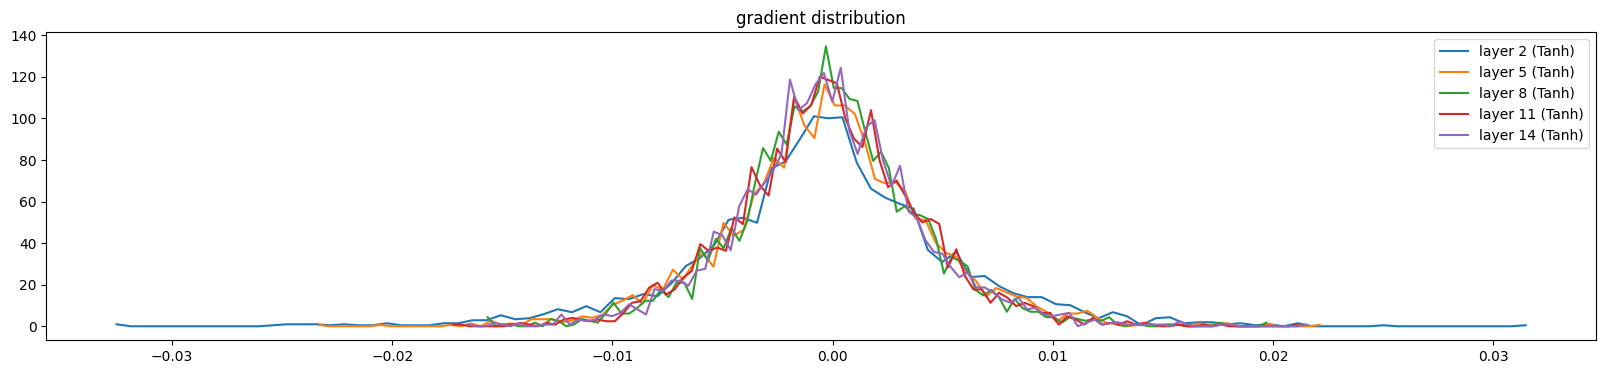

In [55]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh) or i == len(layers)-1:
        t = layer.out.grad 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():f}, std {t.std().item():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('gradient distribution');

weights (27, 10) | mean +0.000000 | std 1.890083e-02 | grad:data ratio 1.730510e-02
weights (30, 100) | mean -0.000013 | std 9.848039e-03 | grad:data ratio 2.398961e-02
weights (100, 100) | mean +0.000046 | std 6.508061e-03 | grad:data ratio 2.641450e-02
weights (100, 100) | mean +0.000028 | std 6.476468e-03 | grad:data ratio 2.668833e-02
weights (100, 100) | mean -0.000062 | std 6.101056e-03 | grad:data ratio 2.570566e-02
weights (100, 100) | mean -0.000023 | std 5.928427e-03 | grad:data ratio 2.582744e-02
weights (100, 27) | mean -0.000109 | std 9.363175e-03 | grad:data ratio 2.816584e-02


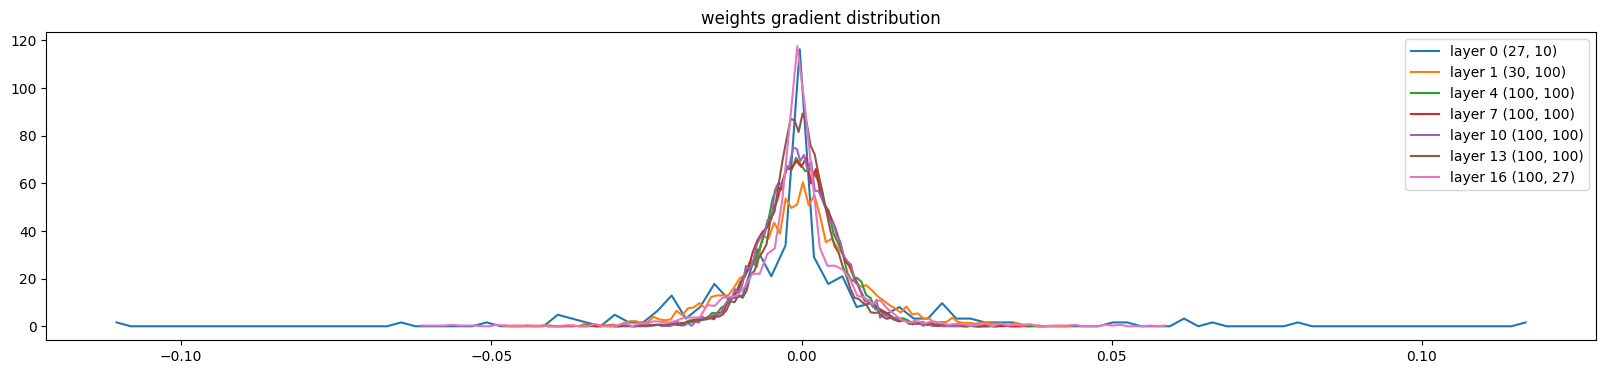

In [56]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad 
        print(f"weights {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std()/p.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution');

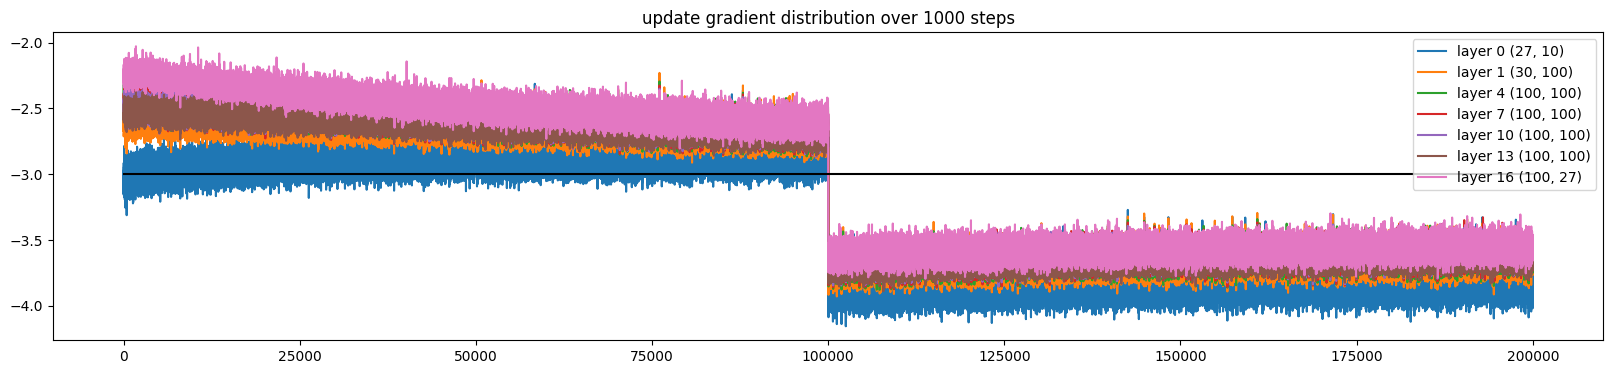

In [57]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('update gradient distribution over 1000 steps');

In [58]:
@torch.no_grad() 
def split_loss(split):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False 
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] 
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [59]:
split_loss('train')
split_loss('val')

train 2.011775255203247
val 2.0835397243499756


In [60]:
# sampling 
@torch.no_grad()
def sample_names():
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False 
    for _ in range(20):
        out = [] 
        context = [0] * block_size 
        while True:
            emb = C[context] 
            x = emb.view(-1, n_embd * block_size)
            for layer in layers:
                x = layer(x)
            probs = F.softmax(x, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix] 
            out.append(ix)
            if ix==0:
                break
        print(''.join(itos[ix] for ix in out))

In [61]:
sample_names()

grace.
tamiab.
neva.
melamiah.
niwie.
vir.
sha.
jaquan.
sharubekaiverichara.
tian.
karleiyadonne.
lor.
shaypauli.
millowdin.
sadalexton.
maven.
aver.
amranderrelli.
remibagan.
gabbanhedsleyna.


## Exercise 
by Andrej Karpathy
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.


## E01. 

Based on the diagnostic graphs plotted below, we can see that only the bias of last layer is being trained. Gradients that are not zero only exist for this bias values. 

The reason is that when we calculate the gradients of weight, it should be something like ```weight.grad = x.data * out.grad```. The input ```x``` to the layer should be zero except for the first layer because all weights and biases are initialized to zero. The first layer's gradients should be also zero because ```out.grad``` should be zero for the first layer.(```out.grad = weight_next.data * out_next.grad = 0```) In addition, putting zero into ```Tanh()``` results only in zero. Thus, all gradients for weights are zero.

Similarly the gradients of biases should be something like ```bias.grad = out.grad```. Since ```out.grad = x_next.grad = weight_next.grad * out_next.grad = 0``` except for the last layer, bias gradiets should be also zero. There are non zero gradients for the last layer's bias because ```out.grad``` is non zero value from softmax. 

layer 1 (Tanh      ): mean 0.00, std 0.00, saturated 0.00%
layer 3 (Tanh      ): mean 0.00, std 0.00, saturated 0.00%
layer 5 (Tanh      ): mean 0.00, std 0.00, saturated 0.00%
layer 7 (Tanh      ): mean 0.00, std 0.00, saturated 0.00%
layer 9 (Tanh      ): mean 0.00, std 0.00, saturated 0.00%
layer 10 (Linear    ): mean 0.00, std 0.91, saturated 37.04%
layer 1 (Tanh      ): mean 0.000000, std 0.000000e+00
layer 3 (Tanh      ): mean 0.000000, std 0.000000e+00
layer 5 (Tanh      ): mean 0.000000, std 0.000000e+00
layer 7 (Tanh      ): mean 0.000000, std 0.000000e+00
layer 9 (Tanh      ): mean 0.000000, std 0.000000e+00
layer 10 (Linear    ): mean 0.000000, std 5.807572e-03
weights (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weights (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weights (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weights (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weights (

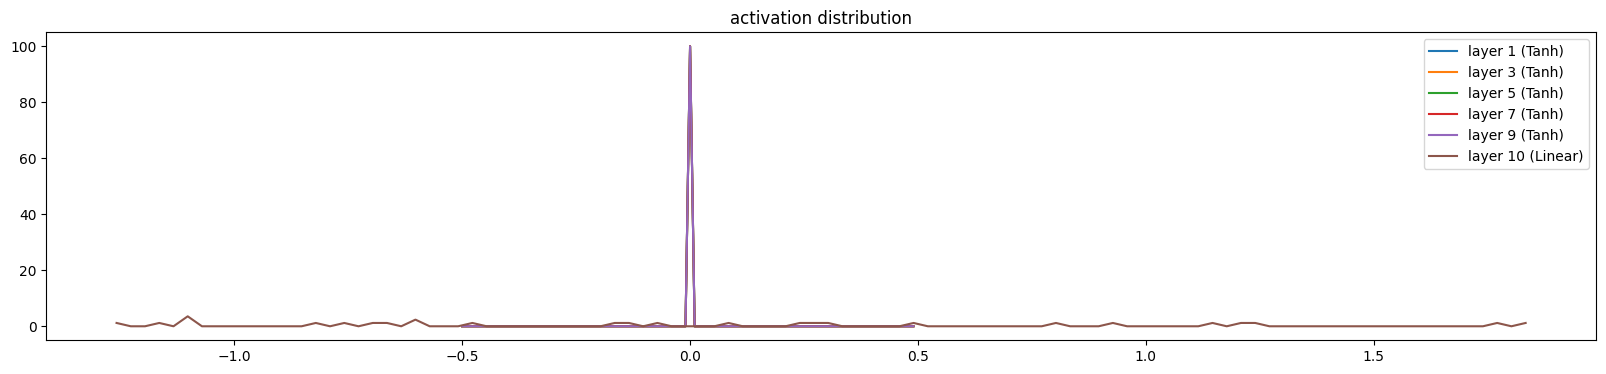

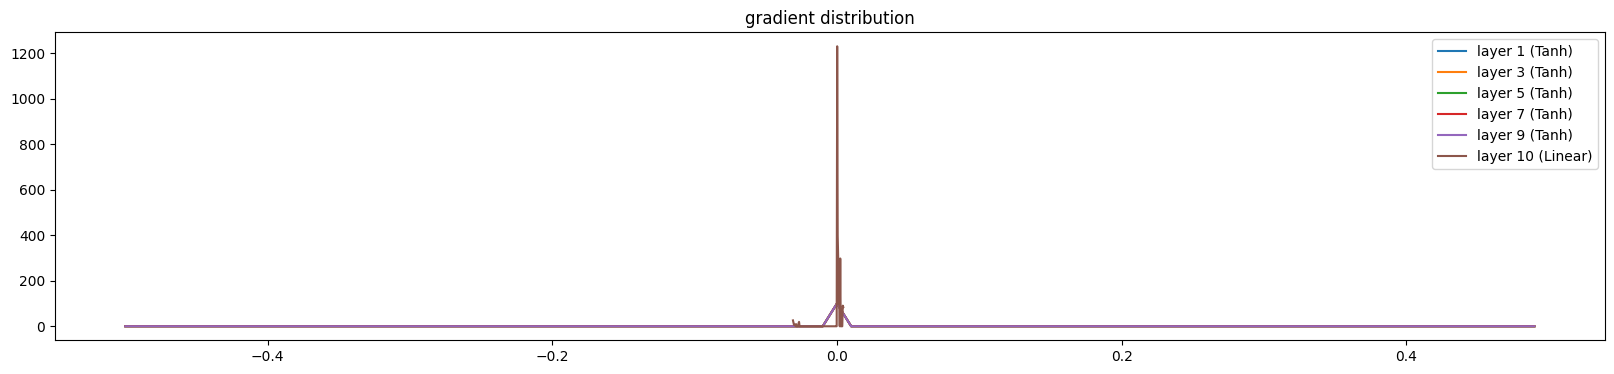

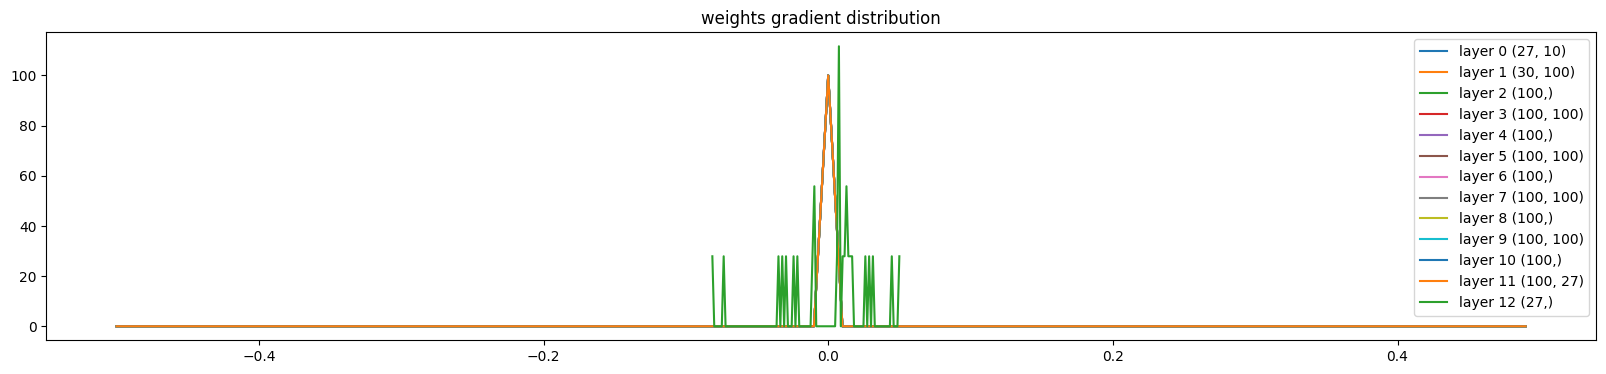

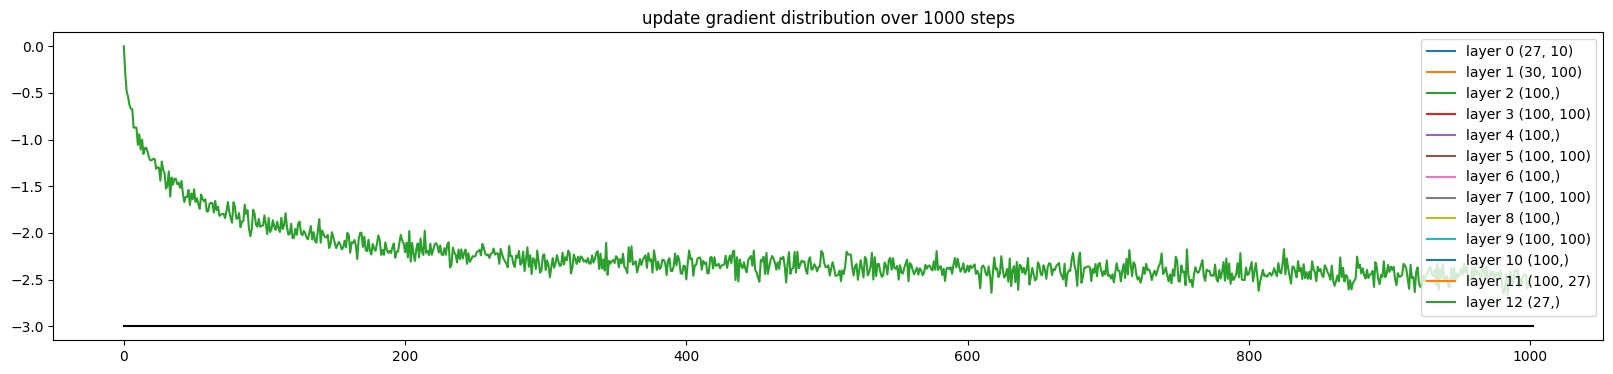

In [43]:
# E01

# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh) or i == len(layers)-1:
        t = layer.out 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():.2f}, std {t.std().item():.2f}, saturated {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title('activation distribution');

# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh) or i == len(layers)-1:
        t = layer.out.grad 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():f}, std {t.std().item():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('gradient distribution');

# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
        t = p.grad 
        print(f"weights {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std()/p.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution');

# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('update gradient distribution over 1000 steps');


## E02.

I checked the outputs are the same for both the default model and the updated model of which BatchNorm1d layers are converted to Linear layers. The conversion code snippet is shown below. 
```python
dim = layer.running_mean.shape[0]
bn_linear = Linear(dim ,dim, bias=True)
running_std = torch.sqrt(layer.running_var)
weight_diags = (layer.gamma / running_std).squeeze()
weight = torch.diag(weight_diags)
bias = (layer.beta - layer.gamma / running_std * layer.running_mean).squeeze()
bn_linear.weight = weight 
bn_linear.bias = bias 
```

In [62]:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 100 
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # make last layer less confident 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain for tanh 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"number of paramters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of paramters = 16424


In [63]:
max_steps = 200000
batch_size = 32 
lossi = [] 
ud = []

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  

    # backward pass 
    for layer in layers:
        layer.out.retain_grad() # DEBUGGING gradient 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    # if i > 1000:
    #     break # DEBUG purpose 

      0/ 200000: 3.271821
  10000/ 200000: 2.716803
  20000/ 200000: 2.079074
  30000/ 200000: 2.037885
  40000/ 200000: 1.973324
  50000/ 200000: 2.248874
  60000/ 200000: 2.177178
  70000/ 200000: 2.135273
  80000/ 200000: 2.151793
  90000/ 200000: 2.333997
 100000/ 200000: 2.137651
 110000/ 200000: 1.854356
 120000/ 200000: 2.456338
 130000/ 200000: 2.551262
 140000/ 200000: 2.023279
 150000/ 200000: 2.235964
 160000/ 200000: 2.271179
 170000/ 200000: 2.180074
 180000/ 200000: 2.440597
 190000/ 200000: 2.254689


In [87]:
bn_linear_layers = [] 
for i, layer in enumerate(layers):
    if layer.__class__.__name__ == 'BatchNorm1d':
        dim = layer.running_mean.shape[0]
        bn_linear = Linear(dim ,dim, bias=True)
        running_std = torch.sqrt(layer.running_var)
        weight_diags = (layer.gamma / running_std).squeeze()
        weight = torch.diag(weight_diags)
        bias = (layer.beta - layer.gamma / running_std * layer.running_mean).squeeze()
        bn_linear.weight = weight 
        bn_linear.bias = bias 
        bn_linear_layers.append(bn_linear)
    else:
        bn_linear_layers.append(layer)

In [129]:
# sampling 
with torch.no_grad():
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False 
    for _ in range(1):
        out = [] 
        out_bn = [] 
        context = [0] * block_size 
        while True:
            emb = C[context] 
            x = emb.view(-1, n_embd * block_size)
            xbn = x 
            for layer, bn_layer in zip(layers, bn_linear_layers):
                x = layer(x)
                xbn = bn_layer(xbn)
                
            probs = F.softmax(x, dim=1)
            probs_bn = F.softmax(xbn, dim=1)
            print(probs.argmax())
            print(probs_bn.argmax())
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix] 
            out.append(ix)
            if ix==0:
                break
    
        print(''.join(itos[ix] for ix in out))    

tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(18)
tensor(18)
tensor(5)
tensor(5)
tensor(14)
tensor(14)
tensor(0)
tensor(0)
tydyn.
